## Generate WordClouds and Statistics for Tag Emotions

This notebook generated wordclouds and computes some general statistics for unique tag strings that were predicted to express a given emotion.

In [1]:
import mysql.connector
import typing as T
from mysql.connector import errorcode
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from utils import get_db_connection, execute_sql

# Downloading NLTK stopwords only needs to be done once
# import nltk
# nltk.download('stopwords')

STOP_WORDS = stopwords.words('english')

In [2]:
GET_LABELS = "SELECT name, score, emotion FROM Tag;"

rows = execute_sql(get_db_connection(), GET_LABELS)

In [13]:
df = pd.read_sql("SELECT name, score, emotion FROM Tag", get_db_connection())

/tmp/ipykernel_2705385/1845362392.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT name, score, emotion FROM Tag", get_db_connection())


In [14]:
df.sample(5)

,name,score,emotion
70179,Australian movie,0.742679,neutral
72486,don't you love it when it's the right length?,0.338131,neutral
8245,bad stereotypes of women,0.649599,disgust
38750,village council,0.761620,neutral
7297,hopeless,0.878486,neutral


In [52]:
df.emotion.value_counts()

neutral     56175
joy          4046
sadness      3838
disgust      3806
anger        2595
fear         2538
surprise     1712
Name: emotion, dtype: int64

In [48]:
# Minor text cleaning for creating wordclouds
df["clean_name"] = df["name"].str.casefold()
df["clean_name"] = df["clean_name"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))
df.sample(5)

,name,score,emotion,ngrams,clean_name
12976,silk,0.867922,neutral,[],silk
71742,Dr. Facilier,0.945786,neutral,[Dr. Facilier],dr. facilier
2134,beautifully filmed,0.972731,joy,[beautifully filmed],beautifully filmed
24879,German movie,0.448408,neutral,[German movie],german movie
4081,outstanding acting,0.283583,neutral,[outstanding acting],outstanding acting


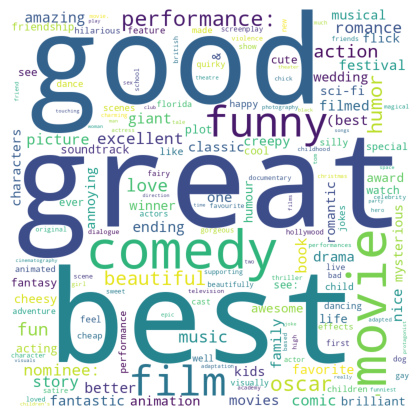

In [47]:
def get_wordcloud(df: pd.DataFrame, column: str = "clean_name") -> WordCloud:
    """
    Compute and return a wordcloud for a given set of strings.
    """
    wordcloud = WordCloud(
        width=800, 
        height=800, 
        background_color="white", 
        min_font_size=10, 
        collocation_threshold=2
    ).generate_from_frequencies(df[column].str.split(expand=True).stack().value_counts().to_dict())  
    
    return wordcloud

wordcloud = get_wordcloud(df.loc[df["emotion"] == "joy"])

plt.figure(figsize=(4,4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

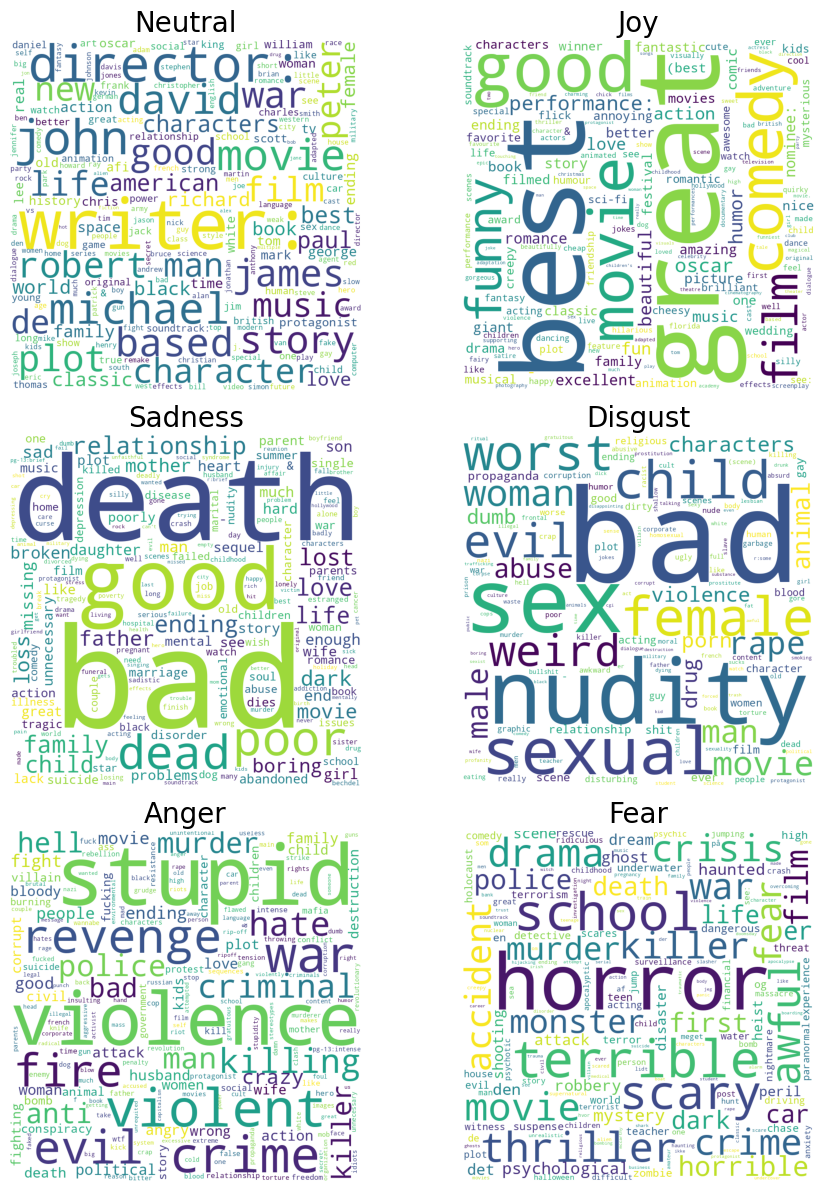

In [60]:
def compute_wordclouds(df: pd.DataFrame, column: str = "emotion") -> None:
    """
    Generate wordclouds for each of the emotions expressed in the dataframe's emotion column.
    """
    fig, axis = plt.subplots(3, 2, figsize=(10, 12))
    emotions = df[column].value_counts().keys().tolist()

    index = 0
    for i in range(3):
        for j in range(2):
            wc = get_wordcloud(df.loc[df[column] == emotions[index]])
            axis[i, j].imshow(wc)
            axis[i, j].set_title(str(emotions[index]).title(), fontsize=20)
            axis[i, j].axis("off")
            index += 1

    plt.tight_layout(pad=1)
    plt.show()

compute_wordclouds(df)

In [61]:
df[["emotion", "score"]].groupby("emotion").mean()

,score
emotion,
anger,0.614832
disgust,0.615616
fear,0.658072
joy,0.677630
neutral,0.735985
sadness,0.644302
surprise,0.564010


In [62]:
df[["emotion", "score"]].groupby("emotion").std()

,score
emotion,
anger,0.198520
disgust,0.189565
fear,0.237443
joy,0.193883
neutral,0.153312
sadness,0.203342
surprise,0.177487


In [63]:
df[["emotion", "score"]].groupby("emotion").max()

,score
emotion,
anger,0.993621
disgust,0.984813
fear,0.994556
joy,0.990852
neutral,0.976205
sadness,0.991065
surprise,0.984219


In [64]:
df[["emotion", "score"]].groupby("emotion").min()

,score
emotion,
anger,0.186174
disgust,0.201867
fear,0.216177
joy,0.240433
neutral,0.201999
sadness,0.215101
surprise,0.210332


In [ ]:
# Generate bi-grams
# from nltk import ngrams

# df['ngrams'] = df['name'].str.split().apply(lambda x: list(map(' '.join, ngrams(x, n=2))))
# (df.assign(count=df['ngrams'].str.len())
#    .explode('ngrams')
#    .query('count > 0')
# )